In [ ]:
# np.set_printoptions(edgeitems=30, linewidth=100000) #Esto es para ajustar el ancho de la celda 
    # formatter=dict(float=lambda x: "%.10g" % x)) #y esto para la cantidad de decimales que queres que te imprima (no recomiendo)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import cv2
from scipy.stats import stats
import matplotlib.image as mpimg
import time
import copy as cp

def norm2(v):
  suma = 0
  for i in range(v.size):
    suma += v[i]**2
  return float(suma)

def sortear_en_esfera(dimension):
  ret = [0 for _ in range(dimension)]
  for i in range(dimension):
    ret[i] = np.random.normal()
  ret = np.array(ret)
  ret /= np.linalg.norm(ret)
  return ret

class EigenGame:
  def __init__(self,n,k,components,expected_components,ruido):
    self.n = n #dimension de las muestras
    self.k = k #cantidad de muestras
    self.components = components #componentes principales reales de mi espacio
    self.expected_components = expected_components #cantidad de componentes que quiero hallar
    self.ruido = ruido #ruido que le pongo a las muestas
    self.tiempos = [] #cuanto tiempo tarde en calcular cada componente
    self.iteraciones = [] #cuantas iteraciones tarde en calcular cada componente
    self.id = np.eye(n)
    assert(components >= expected_components)

    dir = [sortear_en_esfera(n) for _ in range(components)]
    X = np.zeros((k,n))
    weights = np.random.normal(size = (k,components)) #sorteo cuanto de cada componente va a tener cada muestra
    for i in range(k):
      for j in range(components):
        X[i] += dir[j]*weights[i][j]
      X[i] += ruido*sortear_en_esfera(n) #le agrego una componente de ruido aleatoria
    # X = X - np.mean(X.T, axis=1) #esta linea hace que las columnas de X tengan promedio 0
    self.dir = dir
    self.M = np.matmul(X.T,X) #shape (n,n)
    self.X = X #shape (k,n)

    self.vectors = np.eye(n)
    self.Mv = [np.dot(self.M,self.vectors[i]) for i in range(n)] #vectores de n filas
    self.vtMv = [np.dot(self.vectors[i].T,self.Mv[i]) for i in range(expected_components)]
    self.vMv = np.array([[np.dot(self.vectors[i],self.Mv[j]) for j in range(expected_components)] for i in range(expected_components)])

  def set_M_y_vectores_iniciales(self,M, v = 0):
    if v == 0:
      self.vectors = np.eye(self.n)
    else :
      self.vectors = v
    self.M = M
    self.Mv = [np.dot(self.M,self.vectors[i]) for i in range(self.n)] #vectores de n filas
    self.vtMv = [np.dot(self.vectors[i].T,self.Mv[i]) for i in range(self.expected_components)]
    self.vMv = np.array([[np.dot(self.vectors[i],self.Mv[j]) for j in range(self.expected_components)] for i in range(self.expected_components)])

  def util(self, vector, i):
    Mvector = np.dot(self.M,vector)
    answer = np.dot(vector.T,Mvector)
    for j in range(i):
      answer -= (np.dot(vector.T,self.Mv[j])**2)/self.vtMv[j]
    return answer

  def evolutivo(self,T,error):
    start_time = time.time()
    for i in range(self.expected_components):
      step = 32
      for t in range(T):
        if step < error:
          print(i+1, t+1,  time.time() - start_time, (time.time() - start_time)/(t+1))
          self.tiempos.append(time.time() - start_time)
          self.iteraciones.append(t)
          start_time = time.time()
          break
        candidato = self.vectors[i]
        utilidad = self.util(candidato,i)
        unmodified = True
        for jj in range(2*self.n):
          j = jj//2
          sumo = True if jj%2==0 else False
          nuevo = self.vectors[i]+step*self.id[j] if sumo else self.vectors[i]-step*self.id[j]
          nuevo /= np.linalg.norm(nuevo)
          utilidad_nueva = self.util(nuevo,i)
          if utilidad_nueva > utilidad:
            candidato = nuevo
            utilidad = utilidad_nueva
            unmodified = False
        if unmodified :
          step /= 2
        else:
          self.vectors[i] = candidato
          self.Mv[i] = np.dot(self.M,self.vectors[i])
          self.vtMv[i] = np.dot(self.vectors[i].T,self.Mv[i])
        if t == T-1:
          print("ATENCION ATENCION ATENCION", i+1, t+1,  time.time() - start_time, (time.time() - start_time)/(t+1))
          self.tiempos.append(time.time() - start_time)
          self.iteraciones.append(t)
          start_time = time.time()
    return self.vectors[0:self.expected_components]
  
  def u2(self, j, i, sign, step):
    Mvector = cp.deepcopy(self.Mv[i])
    vector = cp.deepcopy(self.vectors[i])
    if sign == '+':
      Mvector += step*self.M.T[j]
      vector += step*self.id[j]
    if sign == '-':
      Mvector -= step*self.M.T[j]
      vector -= step*self.id[j]
    Mvector /= np.linalg.norm(vector) #v1
    vector /= np.linalg.norm(vector) #v1
    answer = np.dot(vector.T,Mvector)
    for k in range(i):
      answer -= (np.dot(vector.T,self.Mv[k])**2)/self.vtMv[k] #v1
      # if sign == '+': #v2
      #   answer -= ((self.vMv[i][k] + step*self.Mv[k][j] )**2)/self.vtMv[k] #v2
      # if sign == '-': #v2
      #   answer -= ((self.vMv[i][k] - step*self.Mv[k][j] )**2)/self.vtMv[k] #v2
    return answer#/norm2(vector) #v2

  def evolutivo2(self,T,error):
    start_time = time.time()
    for i in range(self.expected_components):
      step = 32
      for t in range(T):
        if step < error:
          for j in range(self.expected_components):
            self.vMv[j][i] = np.dot(self.vectors[j], self.Mv[i])
          print(i+1, t+1,  time.time() - start_time, (time.time() - start_time)/(t+1))
          self.tiempos.append(time.time() - start_time)
          self.iteraciones.append(t)
          start_time = time.time()
          break
        candidato = cp.deepcopy(self.vectors[i])
        utilidad = self.u2(0,i,'n',0)
        unmodified = True
        for jj in range(2*self.n):
          j = jj//2
          sumo = True if jj%2==0 else False
          nuevo = self.vectors[i]+step*self.id[j] if sumo else self.vectors[i]-step*self.id[j]
          nuevo /= np.linalg.norm(nuevo)
          utilidad_nueva = self.u2(j,i,'+',step) if sumo else self.u2(j,i,'-',step)
          if utilidad_nueva > utilidad and not np.isclose(utilidad_nueva, utilidad):
            # print("entre", t)
            candidato = cp.deepcopy(nuevo)
            utilidad = cp.deepcopy(utilidad_nueva)
            unmodified = False
        if unmodified :
          step /= 2
          # print(t,"dividi", utilidad)
        else:
          # print(t, utilidad)
          self.vectors[i] = cp.deepcopy(candidato)
          self.Mv[i] = np.dot(self.M,self.vectors[i])
          self.vtMv[i] = np.dot(self.vectors[i].T,self.Mv[i])
          for j in range(i):
            self.vMv[i][j] = np.dot(self.vectors[j].T,self.Mv[i])
        if t == T-1:
          print(i+1, t+1,  time.time() - start_time, (time.time() - start_time)/(t+1))
          self.tiempos.append(time.time() - start_time)
          self.iteraciones.append(t)
          start_time = time.time()
    return self.vectors[0:self.expected_components]

In [ ]:
np.set_printoptions(edgeitems=30, linewidth=100000) #Esto es para ajustar el ancho de la celda

def kill_zeros(matrix):
  copy = matrix
  for i in range(len(matrix)):
    for j in range(len(matrix)):
      if abs(copy[i][j]) < 1e-6:
        copy[i][j] = 0
  return copy

respuestas = []
enes = [1000]
cant_de_componentes = 5
while True:
  for i in enes:
    eg = EigenGame(i,3*i,2*cant_de_componentes,cant_de_componentes,1)
    v = eg.evolutivo(100000,1e-7)
    respuestas.append(eg.iteraciones)
    print(kill_zeros(np.matmul(v,v.T)))
    print(kill_zeros(np.matmul(v,np.matmul(eg.M,v.T))))#/(eg.n*eg.n*eg.k*eg.k)))
  print(respuestas)
  respuestas = []


# print("=================")
# print(respuestas)
#respuestas[i][j] nos dice cuantas iteraciones hizo para calcular la (j+1)-esima componente con cant_de_muestras[i] muestras

In [ ]:
1 10999 7388.58493065834 0.6717506075612045
2 19703 13187.992851495743 0.6693393317344908

1 10777 6995.673561573029 0.6491299585231085
2 14524 9580.5042719841 0.6596326269219644
3 12009 7812.386616230011 0.6505443099258007

1 12558 6227.68852519989 0.49591404098028363
2 11755 5987.371621370316 0.5093467989864374
3 17222 8960.161793708801 0.5202741722462

# total = 109547÷8 = 13693,375


def kill_zeros(matrix):
  copy = matrix
  for i in range(len(matrix)):
    for j in range(len(matrix)):
      if abs(copy[i][j]) < 5e-7:
        copy[i][j] = 0
  return copy

respuestas = []
dimensiones = [50,100,200,300,500,700]#,1000]
cant_de_componentes = 5
vectores = []
while True:
  for i in dimensiones:
    eg = EigenGame(i,3*i,cant_de_componentes,cant_de_componentes,1)
    v = eg.evolutivo(100000,1e-7)
    vectores.append(v)
    respuestas.append(eg.iteraciones)
    print(i)
    print(kill_zeros(np.matmul(v,v.T)))
    print(kill_zeros(np.matmul(v,np.matmul(eg.M,v.T))/(eg.n*eg.n*eg.k*eg.k)))
  print(respuestas)
  respuestas = []


# print("=================")
# print(respuestas)
#respuestas[i][j] nos dice cuantas iteraciones hizo para calcular la (j+1)-esima componente con cant_de_muestras[i] muestras

50
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
[[1.38238024 0.         0.         0.         0.        ]
 [0.         1.2082956  0.         0.         0.        ]
 [0.         0.         1.09048307 0.         0.        ]
 [0.         0.         0.         0.75832283 0.        ]
 [0.         0.         0.         0.         0.37138312]]
100
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
[[1.31509008 0.         0.         0.         0.        ]
 [0.         1.09342689 0.         0.         0.        ]
 [0.         0.         0.95556256 0.         0.        ]
 [0.         0.         0.         0.8836497  0.        ]
 [0.         0.         0.         0.         0.70367005]]
200
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
[[1.16007394 0.         0.         0.         0.        ]
 [0.         1.07349517 0.         0.         0.        ]
 [0.         0.   

KeyboardInterrupt: ignored

In [ ]:
np.set_printoptions(edgeitems=30, linewidth=100000) #Esto es para ajustar el ancho de la celda

def kill_zeros(matrix):
  copy = matrix
  for i in range(len(matrix)):
    for j in range(len(matrix)):
      if abs(copy[i][j]) < 1e-5:
        copy[i][j] = 0
  return copy

print(kill_zeros(np.matmul(v,v.T)))
print("----------------------")
print(kill_zeros(np.matmul(v,np.matmul(eg.M,v.T))/(eg.n*eg.n*eg.k*eg.k)))

NameError: ignored

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import cv2
from scipy.stats import stats
import matplotlib.image as mpimg


A=eg.M
pca_a = PCA(n_components = eg.components)
# pca_a = PCA(n_components=None)
pca_a.fit(A)
trans_pca_a = pca_a.transform(A)  # estos son nuestros datos originales pero en los ejes de las componentes principales

XX=trans_pca_a

Dimensiones de la matriz de componentes principales (50, 10)
Suma de la varianza explicada : 0.9999999999999984


<BarContainer object of 10 artists>

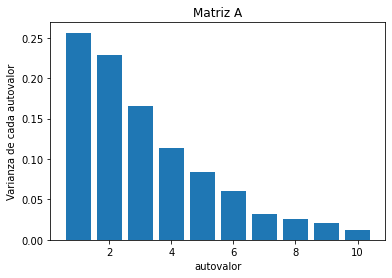

In [ ]:
print('Dimensiones de la matriz de componentes principales', trans_pca_a.shape)
print(f"Suma de la varianza explicada : {sum(pca_a.explained_variance_ratio_)}") 

fig = plt.figure()  
plt.title("Matriz A")
plt.ylabel('Varianza de cada autovalor')
plt.xlabel('autovalor')
plt.bar(list(range(1,11)),pca_a.explained_variance_ratio_)

In [ ]:
print('Componentes principales \n')
# for i in range(10):
#   print(pca_a.components_[i])
print(np.dot( pca_a.components_ , v.T))

print(' \n \n Filas de A en las componentes principales \n')
for i in range(10):
  print(XX[i])

Saving ChladniFigures.png to ChladniFigures.png
(1036, 850, 3)


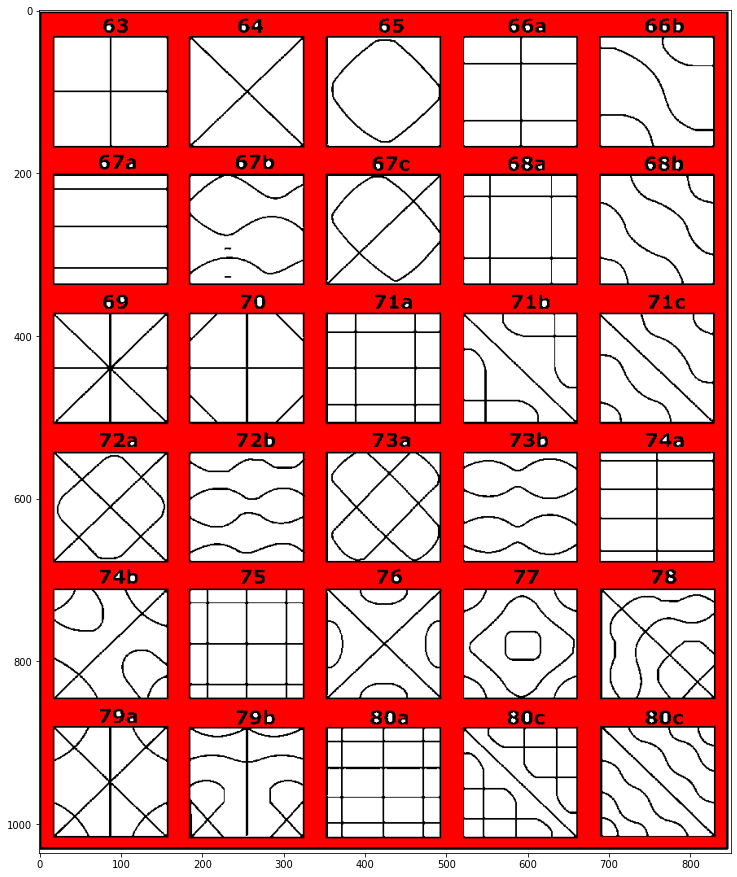

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab import files
from matplotlib.image import imread
uploaded = files.upload()
imagen_cruda = cv2.imread("ChladniFigures.png")
print(imagen_cruda.shape)
imagen = imagen_cruda
for i in range(1036):
  for j in range(850):
    for k in range(3):
      imagen[i][j][k] = 0 if imagen_cruda[i][j][0] < 100 else 255


queue = []

def es_blanco(pixel):
  return pixel[0] == 255 and pixel[1] == 255

def es_negro(pixel):
  return pixel[0] == 0 and pixel[1] == 0

def es_rojo(pixel):
  return pixel[0] == 255 and pixel[1] == 0

def es_invalido(pixel):
  return pixel[0] != pixel[1]

def tacho(x,y):
  if x < 0 or x >= 1036 or y < 0 or y >= 850:
    return
  if imagen[x][y][1] == 0:
    return
  imagen[x][y][0] = 255
  imagen[x][y][1] = 0
  imagen[x][y][2] = 0
  queue.append([x+1,y])
  queue.append([x-1,y])
  queue.append([x,y+1])
  queue.append([x,y-1])
  return

queue.append([13,15])
indice = 0
while indice < len(queue):
  tacho(queue[indice][0],queue[indice][1])
  indice += 1

im = np.empty((1036,850))
for i in range(1036):
  for j in range(850):
    if imagen[i][j][0] == 0:
      im[i][j] = 0
    else:
      if imagen[i][j][1] == 0:
        im[i][j] = 150
      else:
        im[i][j] = 255


plt.rcParams["figure.figsize"] = (18,15.5)
plt.imshow(imagen)
plt.show()

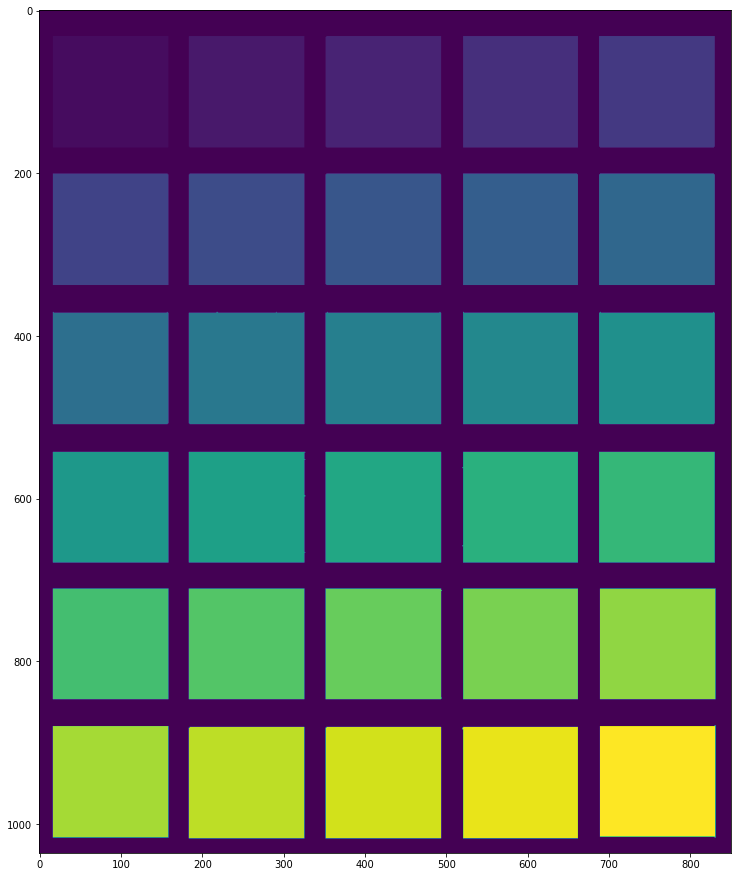

In [ ]:
pixeles_en_imagen_x = [31,194,362,530,698]
pixeles_en_imagen_y = [53,221,391,559,727,896]
pixeles_en_imagen = []
for i in range(6):
  for j in range(5):
    pixeles_en_imagen.append([pixeles_en_imagen_y[i],pixeles_en_imagen_x[j]])

cuadrado = im
for i in range(1036):
  for j in range(850):
    cuadrado[i][j] = -1

def pinto(x,y,indicee):
  if es_invalido(imagen[x][y]) or cuadrado[x][y] == indicee:
    return
  cuadrado[x][y] = indicee
  queue.append([x+1,y])
  queue.append([x-1,y])
  queue.append([x,y+1])
  queue.append([x,y-1])


for i in range(30):
  queue = [pixeles_en_imagen[i]]
  indice = 0
  while indice < len(queue):
    pinto(queue[indice][0],queue[indice][1],i)
    indice += 1

limites = [[[5000,5000],[0,0]] for _ in range(30)]
for i in range(1036):
  for j in range(850):
    if cuadrado[i][j] != -1:
      limites[int(cuadrado[i][j])][0][0] = min(limites[int(cuadrado[i][j])][0][0],i)
      limites[int(cuadrado[i][j])][0][1] = min(limites[int(cuadrado[i][j])][0][1],j)
      limites[int(cuadrado[i][j])][1][0] = max(limites[int(cuadrado[i][j])][1][0],i)
      limites[int(cuadrado[i][j])][1][1] = max(limites[int(cuadrado[i][j])][1][1],j)

plt.rcParams["figure.figsize"] = (18,15.5)
plt.imshow(cuadrado)
plt.show()

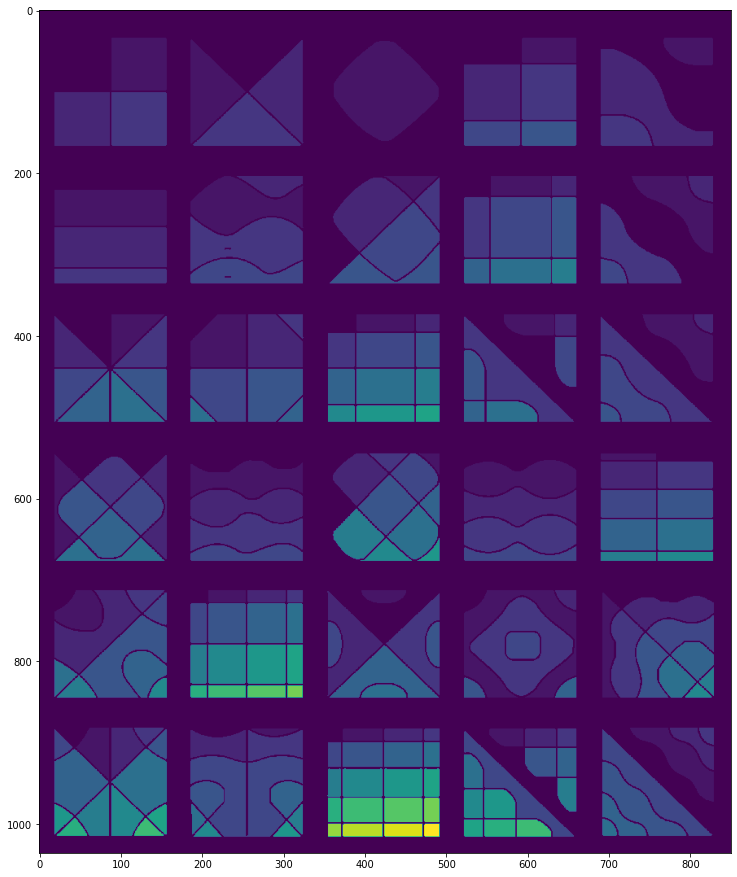

In [ ]:
componente = im
for i in range(1036):
  for j in range(850):
    componente[i][j] = -1

def es_limite(pixel):
  return (pixel[0] == 0 and pixel[1] == 0 and pixel[2] == 0)

def asigno_componente(x,y,num_comp):
  if componente[x][y] != -1 or imagen[x][y][1] == 0:
    return
  componente[x][y] = num_comp
  queue.append([x+1,y,num_comp])
  queue.append([x-1,y,num_comp])
  queue.append([x,y+1,num_comp])
  queue.append([x,y-1,num_comp])

for t in range(30):
  contador = -1
  for i in range(limites[t][0][0],limites[t][1][0]+1):
    for j in range(limites[t][0][1],limites[t][1][1]+1):
      if componente[i][j] == -1 and imagen[i][j][1] == 255:
        indice = 0
        contador += 1
        queue = [[i,j,contador*20]]
        while indice < len(queue):
          asigno_componente(queue[indice][0],queue[indice][1],queue[indice][2])
          indice += 1



plt.rcParams["figure.figsize"] = (18,15.5)
# plt.imshow(imagen_purgada[33:168])
plt.imshow(componente)
plt.show()